In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

Base = automap_base()

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
# reflect the tables
Base.prepare(autoload_with = engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind = engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
# We can use `print(Measurement.__table__.columns)` to see what columns are saved into our data set

# Sorts the Measurement's date column in ascending order and calls the last row to get the latest date recorded
session.query(func.max(Measurement.date)).first()

('2017-08-23',)

In [10]:
# Unfortunately, it does not seem that the date column is in the Date data type
for i in Measurement.__table__.columns:
    print(i, i.type)

measurement.id INTEGER
measurement.station TEXT
measurement.date TEXT
measurement.prcp FLOAT
measurement.tobs FLOAT


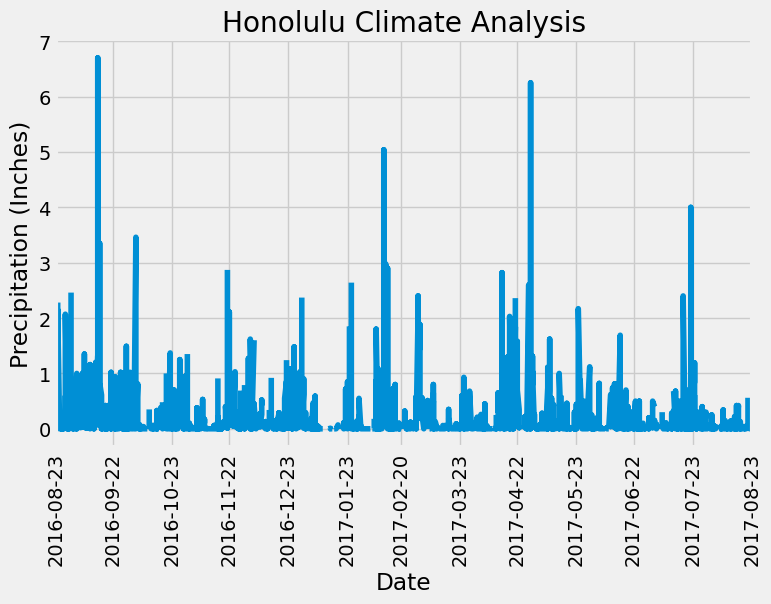

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. The query itself returns a String, so we have to convert that
for i in session.query(func.max(Measurement.date)).first():
    latest_date = dt.datetime.strptime(i, "%Y-%m-%d")

# Calculate the date one year from the last date in data set.
condition_date = latest_date.replace(year=latest_date.year-1)

# A query will be performed on all fields for convenience's sake
query = session.query(Measurement.date, Measurement.prcp, Measurement.station, Measurement.tobs).filter(Measurement.date >= condition_date.strftime("%Y-%m-%d"))

# Save the query results as a Pandas DataFrame. Explicitly set the column names
# We do query.statement to pass in the actual SQL code since Pandas can't handle whatever SQLAlchemy is
prcp_df = pd.read_sql(query.statement, con = engine).rename(columns={"date": "Date", "prcp": "Precipitation (Inches)", "station":"Station ID", "tobs":"Observed Temperature (°F)"})

# Sort the dataframe by date
prcp_df["Date"] = pd.to_datetime(prcp_df["Date"])
prcp_df.sort_values(by="Date", inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
# This bit of code here allows me to customize the xtick intervals for a finicky data type such as Datetime
# It's a bit hacky, but the `.replace` portion allows me to add in one more tick because, like most things in computer science, the declared endpoint of a range is not inclusive
xticks = pd.date_range(prcp_df["Date"].min(), prcp_df["Date"].max().replace(month=prcp_df["Date"].max().month+1), freq="MS") - pd.DateOffset(days=9)
prcp_df.plot(x="Date", y="Precipitation (Inches)", legend=None, figsize=(8,6), xticks=xticks)

# More chart presentation cleanup
plt.xticks(rotation=90, horizontalalignment="center")
plt.xlim(prcp_df["Date"].min(), prcp_df["Date"].max())
plt.ylabel("Precipitation (Inches)")
plt.title("Honolulu Climate Analysis")
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.loc[:,["Precipitation (Inches)"]].describe()

,Precipitation (Inches)
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
# `session.query(Station).count()` technically also works, but the output isn't in the format I desired

session.query(func.count(Station.station)).all()

[(9,)]

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_list = [row for row in session.query(Measurement.station, func.count(Measurement.station))
 .group_by(Measurement.station)
 .order_by(func.count(Measurement.station).desc()).all()]

station_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station==station_list[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

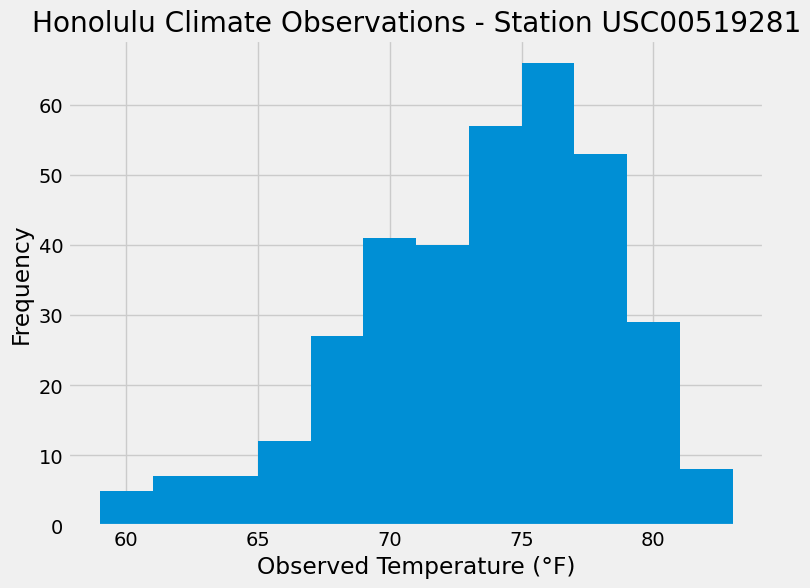

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_df = prcp_df[prcp_df["Station ID"]==station_list[0][0]]

active_station_df["Observed Temperature (°F)"].plot.hist(bins=12, legend=None, figsize=(8,6))

# More chart presentation cleanup
plt.ylabel("Frequency")
plt.xlabel("Observed Temperature (°F)")
plt.title("Honolulu Climate Observations - Station USC00519281")
plt.show()

# Close Session

In [17]:
# Close Session
session.close()